In [1]:
import itertools
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, TfidfModel

import pymorphy2
from nltk.corpus import stopwords
from razdel import tokenize

%matplotlib inline

**Функции из методички**

In [2]:
def clean_text(text):
    '''
    Очистка текста
    '''
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    return text


def lemmatization(text):
    '''
    Лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова
    '''
    # [0]
    if not isinstance(text, str):
        text = str(text)
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]
    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    return words_lem_without_stopwords


def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)


def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Строим модель**

In [3]:
#Загружаем данные
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")
churn = pd.read_csv("users_churn.csv")

In [4]:
import nltk
nltk.download('stopwords')

stopword_ru = stopwords.words('russian')
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [5]:
#Чистим данные
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

cache = {}
morph = pymorphy2.MorphAnalyzer()
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

<ipython-input-2-e47b6884a03c>:10: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


In [6]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = news['title'].tolist()
# Create a corpus from a list of texts
common_dictionary = Dictionary(news['title'].values)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]
# Обучаем LDA модель
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [7]:
#Эмбединги документов по темам
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [8]:
# Получаем эмбеддинги пользователей по темам.
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(get_user_embedding, 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [9]:
# Обучаем логистическую регрессию на данных оттока и эмбеддингах пользователей.
X = pd.merge(user_embeddings, churn, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'],
                                                    random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [10]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc_mean = roc_auc_score(y_test, preds)

Best Threshold=0.268217, F-Score=0.659, Precision=0.656, Recall=0.661


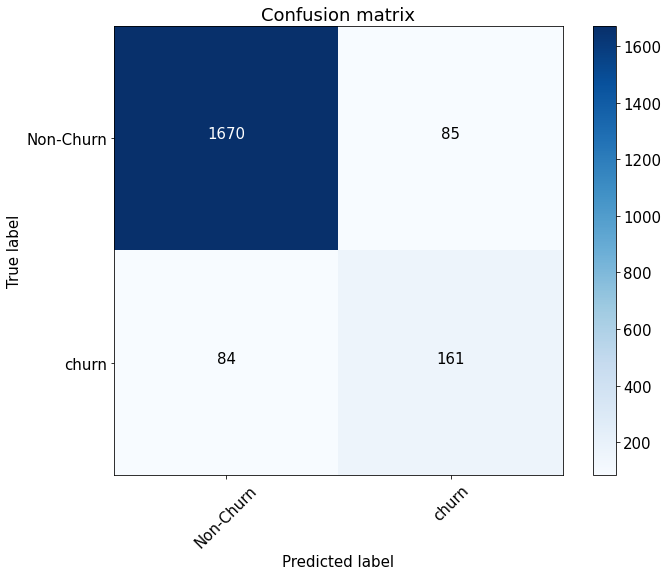

In [11]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [12]:
#Создаем сводную таблицу с результатами
metrics = pd.Series({'precision': precision[ix],
                     'recall': recall[ix],
                     'f1_score': fscore[ix],
                     'roc_auc': roc_auc_mean
                    }).to_frame().T
metrics

,precision,recall,f1_score,roc_auc
0,0.65587,0.661224,0.658537,0.937936


### 1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [13]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [14]:
# Получаем эмбеддинги пользователей по темам.
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(get_user_embedding_median, 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [15]:
# Обучаем логистическую регрессию на данных оттока и эмбеддингах пользователей.
X = pd.merge(user_embeddings, churn, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'],
                                                    random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [16]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc_median = roc_auc_score(y_test, preds)

Best Threshold=0.274671, F-Score=0.778, Precision=0.743, Recall=0.816


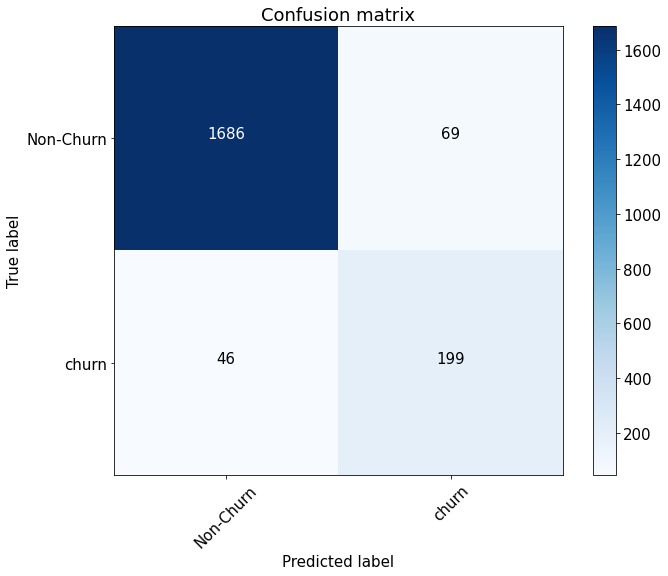

In [17]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [18]:
metrics_median = pd.Series({'precision': precision[ix],
                            'recall': recall[ix],
                            'f1_score': fscore[ix],
                            'roc_auc': roc_auc_median})
metrics = metrics.append(metrics_median, ignore_index=True)
metrics

,precision,recall,f1_score,roc_auc
0,0.655870,0.661224,0.658537,0.937936
1,0.743494,0.816327,0.778210,0.973796


### 3. Повторить п.2, но используя уже не медиану, а max

In [19]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [20]:
# Получаем эмбеддинги пользователей по темам.
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(get_user_embedding_max, 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [21]:
# Обучаем логистическую регрессию на данных оттока и эмбеддингах пользователей.
X = pd.merge(user_embeddings, churn, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'],
                                                    random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [22]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc_max = roc_auc_score(y_test, preds)

Best Threshold=0.332194, F-Score=0.708, Precision=0.673, Recall=0.747


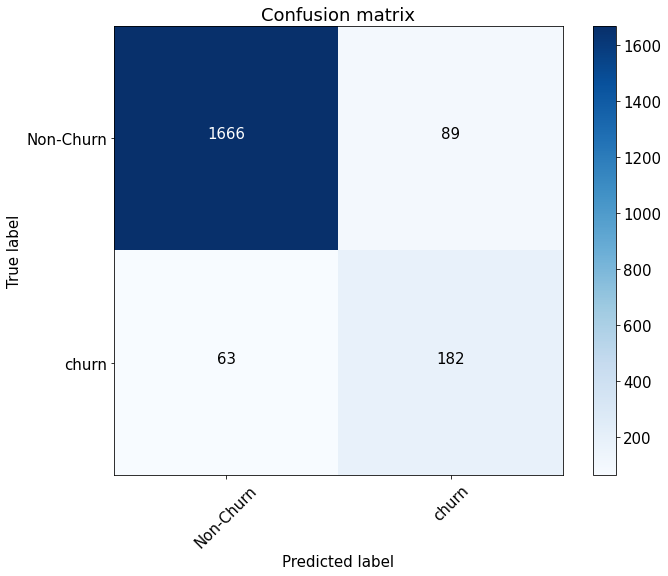

In [23]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [24]:
metrics_max = pd.Series({'precision': precision[ix],
                         'recall': recall[ix],
                         'f1_score': fscore[ix],
                         'roc_auc': roc_auc_max})
metrics = metrics.append(metrics_max, ignore_index=True)

### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [25]:
metrics

,precision,recall,f1_score,roc_auc
0,0.655870,0.661224,0.658537,0.937936
1,0.743494,0.816327,0.778210,0.973796
2,0.672794,0.746939,0.707930,0.955269


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или иной способ оказался эффективнее остальных

User embeddings по медиане сработало лучше, чем по максимальному значению или среднему. Связано это с тем, что медиана более устойчива к выбросам.